# Red Light Violation Detection - Data Exploration

This notebook explores the YOLOv8 format dataset for detecting vehicles crossing red lights.

## Dataset Overview
- **Classes**: 9 classes (bike, bus, car, green_light, motobike, red_light, stop_line, truck, yellow_light)
- **Format**: YOLOv8 (YOLO format with normalized coordinates)
- **Splits**: train, valid, test

In [2]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from collections import Counter
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Dataset Configuration

In [3]:
# Load data.yaml
data_yaml_path = 'data/data.yaml'

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print(f"\nTraining set: {data_config['train']}")
print(f"Validation set: {data_config['val']}")
print(f"Test set: {data_config['test']}")

Dataset Configuration:
Number of classes: 9
Class names: ['bike', 'bus', 'car', 'green_light', 'motobike', 'red_light', 'stop_line', 'truck', 'yellow_light']

Training set: ../train/images
Validation set: ../valid/images
Test set: ../test/images


In [4]:
# Set up paths
data_root = Path('data')
train_images = data_root / 'train' / 'images'
train_labels = data_root / 'train' / 'labels'
valid_images = data_root / 'valid' / 'images'
valid_labels = data_root / 'valid' / 'labels'
test_images = data_root / 'test' / 'images'
test_labels = data_root / 'test' / 'labels'

class_names = data_config['names']

## 2. Dataset Statistics

Dataset Split Statistics:
Train: 2421 images, 2421 labels
Valid: 655 images, 655 labels
Test:  319 images, 319 labels

Total: 3395 images


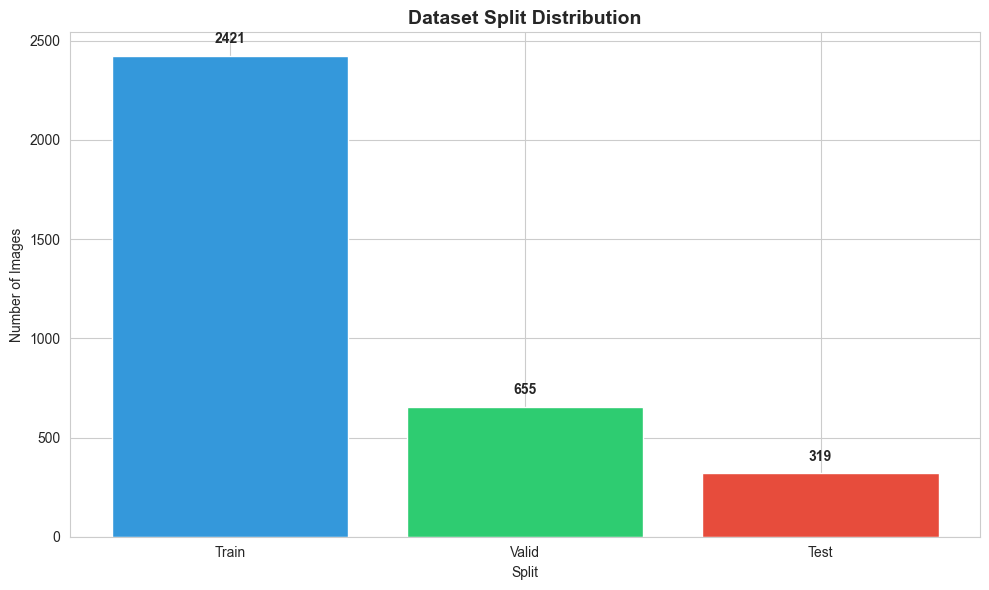

In [5]:
def count_files(image_dir, label_dir):
    """Count images and labels in a directory"""
    images = list(Path(image_dir).glob('*.jpg')) + list(Path(image_dir).glob('*.png'))
    labels = list(Path(label_dir).glob('*.txt'))
    return len(images), len(labels)

train_img_count, train_lbl_count = count_files(train_images, train_labels)
valid_img_count, valid_lbl_count = count_files(valid_images, valid_labels)
test_img_count, test_lbl_count = count_files(test_images, test_labels)

print("Dataset Split Statistics:")
print("="*50)
print(f"Train: {train_img_count} images, {train_lbl_count} labels")
print(f"Valid: {valid_img_count} images, {valid_lbl_count} labels")
print(f"Test:  {test_img_count} images, {test_lbl_count} labels")
print(f"\nTotal: {train_img_count + valid_img_count + test_img_count} images")

# Visualize split distribution
splits = ['Train', 'Valid', 'Test']
counts = [train_img_count, valid_img_count, test_img_count]

plt.figure(figsize=(10, 6))
plt.bar(splits, counts, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Dataset Split Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images')
plt.xlabel('Split')
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Class Distribution Analysis

In [6]:
def analyze_labels(label_dir):
    """Analyze label distribution in a directory"""
    class_counts = Counter()
    bbox_areas = []
    objects_per_image = []
    
    for label_file in Path(label_dir).glob('*.txt'):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            objects_per_image.append(len(lines))
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1
                    
                    # Calculate bbox area (normalized)
                    width = float(parts[3])
                    height = float(parts[4])
                    bbox_areas.append(width * height)
    
    return class_counts, bbox_areas, objects_per_image

print("Analyzing training set...")
train_class_counts, train_bbox_areas, train_objs_per_img = analyze_labels(train_labels)

print("Analyzing validation set...")
valid_class_counts, valid_bbox_areas, valid_objs_per_img = analyze_labels(valid_labels)

print("Analyzing test set...")
test_class_counts, test_bbox_areas, test_objs_per_img = analyze_labels(test_labels)

Analyzing training set...
Analyzing validation set...
Analyzing test set...


In [7]:
# Create class distribution dataframe
class_dist_data = []
for class_id, class_name in enumerate(class_names):
    class_dist_data.append({
        'Class': class_name,
        'Train': train_class_counts.get(class_id, 0),
        'Valid': valid_class_counts.get(class_id, 0),
        'Test': test_class_counts.get(class_id, 0)
    })

df_class_dist = pd.DataFrame(class_dist_data)
df_class_dist['Total'] = df_class_dist['Train'] + df_class_dist['Valid'] + df_class_dist['Test']
df_class_dist = df_class_dist.sort_values('Total', ascending=False)

print("\nClass Distribution:")
print("="*70)
print(df_class_dist.to_string(index=False))


Class Distribution:
       Class  Train  Valid  Test  Total
    motobike   2851    840   425   4116
         car   2295    713   330   3338
   stop_line   1560    478   211   2249
   red_light   1516    464   210   2190
 green_light   1109    314   142   1565
yellow_light    619    117    48    784
       truck    379    129    41    549
        bike    297     86    56    439
         bus    276     84    29    389


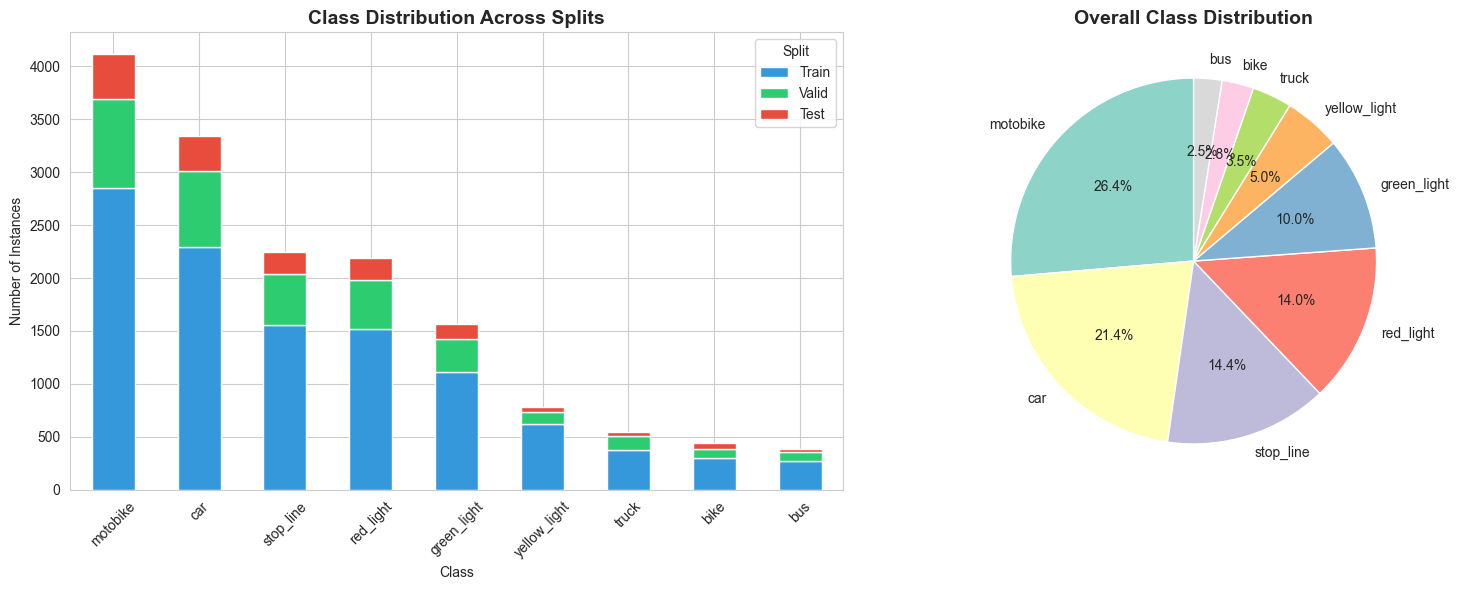

In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
df_class_dist.set_index('Class')[['Train', 'Valid', 'Test']].plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0],
    color=['#3498db', '#2ecc71', '#e74c3c']
)
axes[0].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Instances')
axes[0].set_xlabel('Class')
axes[0].legend(title='Split')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart for total distribution
colors = plt.cm.Set3(range(len(df_class_dist)))
axes[1].pie(
    df_class_dist['Total'], 
    labels=df_class_dist['Class'], 
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Bounding Box Analysis

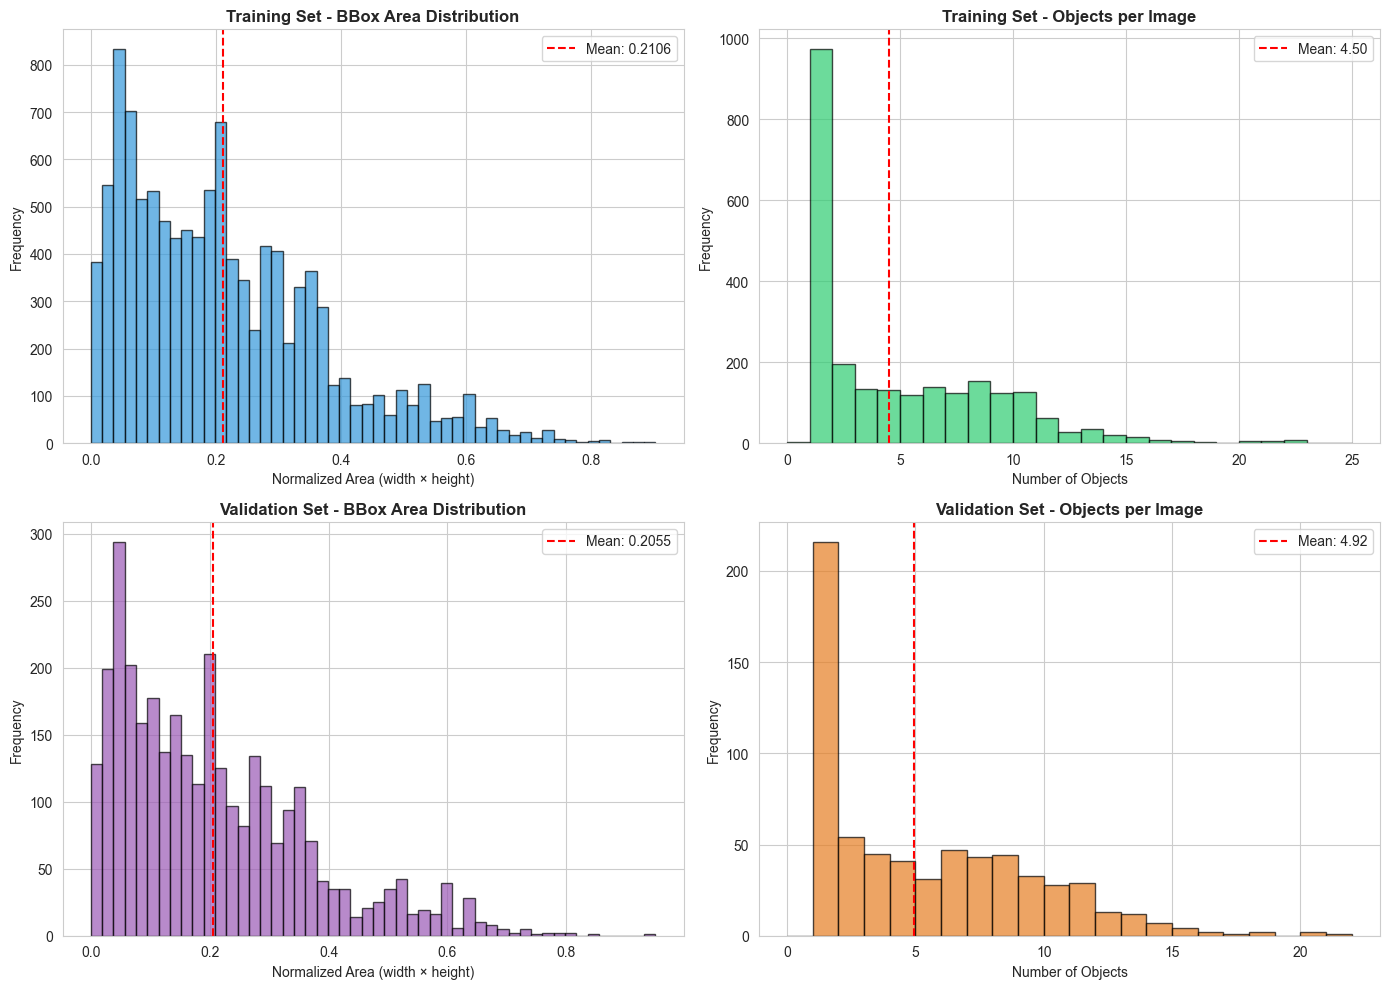


Bounding Box Statistics:
Train - Mean area: 0.2106, Std: 0.1578
Valid - Mean area: 0.2055, Std: 0.1597

Objects per Image:
Train - Mean: 4.50, Max: 24
Valid - Mean: 4.92, Max: 21


In [9]:
# Analyze bounding box sizes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Train bbox area distribution
axes[0, 0].hist(train_bbox_areas, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Training Set - BBox Area Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Normalized Area (width × height)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.mean(train_bbox_areas), color='red', linestyle='--', label=f'Mean: {np.mean(train_bbox_areas):.4f}')
axes[0, 0].legend()

# Objects per image distribution
axes[0, 1].hist(train_objs_per_img, bins=range(0, max(train_objs_per_img)+2), color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Training Set - Objects per Image', fontweight='bold')
axes[0, 1].set_xlabel('Number of Objects')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.mean(train_objs_per_img), color='red', linestyle='--', label=f'Mean: {np.mean(train_objs_per_img):.2f}')
axes[0, 1].legend()

# Valid bbox area distribution
axes[1, 0].hist(valid_bbox_areas, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Validation Set - BBox Area Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Normalized Area (width × height)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.mean(valid_bbox_areas), color='red', linestyle='--', label=f'Mean: {np.mean(valid_bbox_areas):.4f}')
axes[1, 0].legend()

# Valid objects per image
axes[1, 1].hist(valid_objs_per_img, bins=range(0, max(valid_objs_per_img)+2), color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Validation Set - Objects per Image', fontweight='bold')
axes[1, 1].set_xlabel('Number of Objects')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.mean(valid_objs_per_img), color='red', linestyle='--', label=f'Mean: {np.mean(valid_objs_per_img):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nBounding Box Statistics:")
print(f"Train - Mean area: {np.mean(train_bbox_areas):.4f}, Std: {np.std(train_bbox_areas):.4f}")
print(f"Valid - Mean area: {np.mean(valid_bbox_areas):.4f}, Std: {np.std(valid_bbox_areas):.4f}")
print(f"\nObjects per Image:")
print(f"Train - Mean: {np.mean(train_objs_per_img):.2f}, Max: {max(train_objs_per_img)}")
print(f"Valid - Mean: {np.mean(valid_objs_per_img):.2f}, Max: {max(valid_objs_per_img)}")

## 5. Image Resolution Analysis

Sampling images to analyze dimensions...

Image Resolution Statistics (sample of 200 images):
Width  - Min: 222, Max: 1756, Mean: 847
Height - Min: 280, Max: 957, Mean: 692
Aspect Ratio - Mean: 1.17


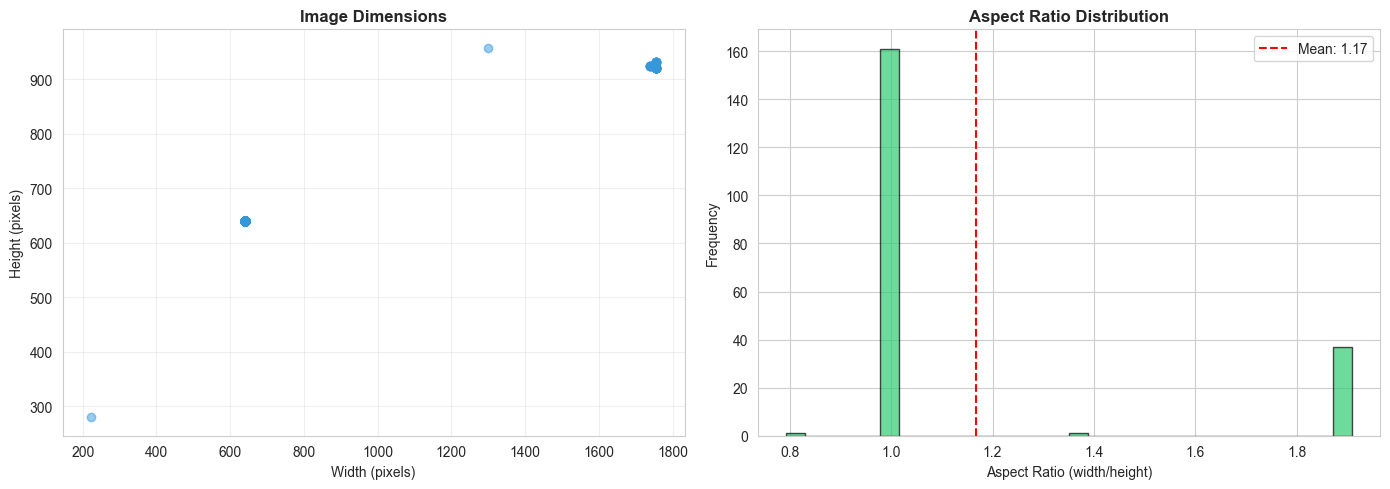

In [10]:
def analyze_image_sizes(image_dir, sample_size=100):
    """Analyze image dimensions"""
    image_files = list(Path(image_dir).glob('*.jpg')) + list(Path(image_dir).glob('*.png'))
    
    # Sample images if too many
    if len(image_files) > sample_size:
        image_files = np.random.choice(image_files, sample_size, replace=False)
    
    widths = []
    heights = []
    aspect_ratios = []
    
    for img_path in image_files:
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)
    
    return widths, heights, aspect_ratios

print("Sampling images to analyze dimensions...")
widths, heights, aspect_ratios = analyze_image_sizes(train_images, sample_size=200)

print(f"\nImage Resolution Statistics (sample of {len(widths)} images):")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
print(f"Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(widths, heights, alpha=0.5, color='#3498db')
axes[0].set_title('Image Dimensions', fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Height (pixels)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(aspect_ratios, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1].set_xlabel('Aspect Ratio (width/height)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Visualize Sample Images with Annotations

In [11]:
def draw_yolo_boxes(image_path, label_path, class_names):
    """Draw YOLO format bounding boxes on image"""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Color map for different classes
    colors = {
        'red_light': (255, 0, 0),
        'green_light': (0, 255, 0),
        'yellow_light': (255, 255, 0),
        'stop_line': (0, 255, 255),
        'car': (255, 0, 255),
        'truck': (128, 0, 128),
        'bus': (255, 128, 0),
        'bike': (0, 128, 255),
        'motobike': (128, 255, 0)
    }
    
    if Path(label_path).exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    width = float(parts[3]) * w
                    height = float(parts[4]) * h
                    
                    # Calculate top-left corner
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    
                    class_name = class_names[class_id]
                    color = colors.get(class_name, (255, 255, 255))
                    
                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Draw label
                    label = f"{class_name}"
                    (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                    cv2.rectangle(img, (x1, y1 - label_h - 10), (x1 + label_w, y1), color, -1)
                    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img

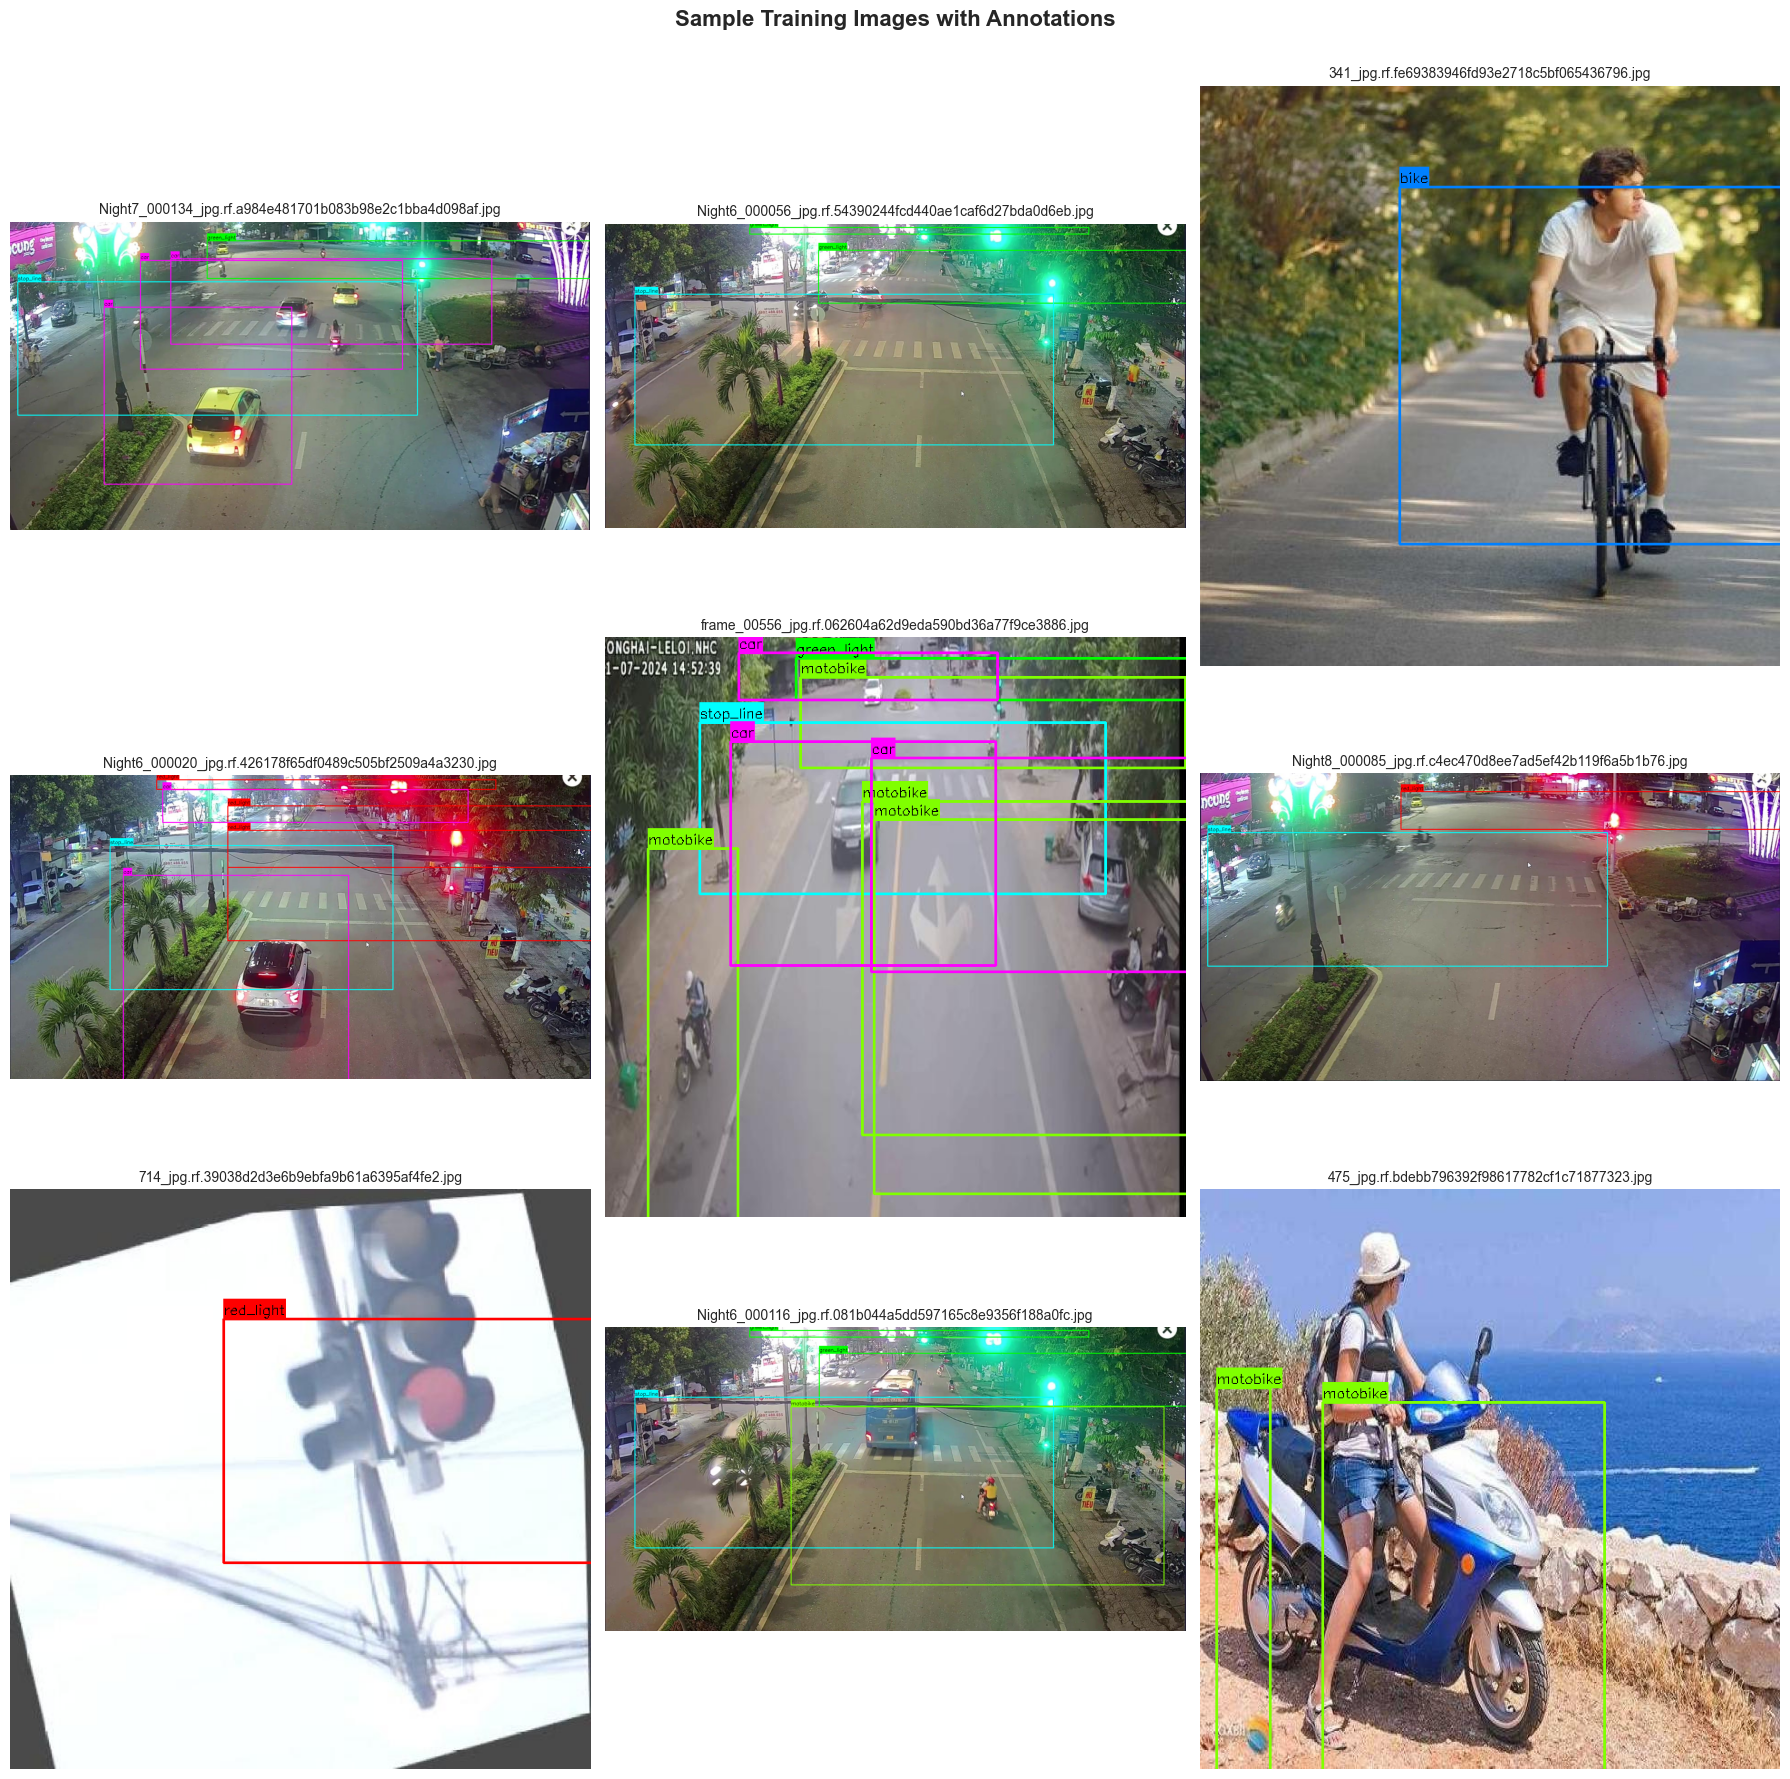

In [12]:
# Visualize random samples from training set
train_image_files = list(train_images.glob('*.jpg'))
sample_indices = np.random.choice(len(train_image_files), min(9, len(train_image_files)), replace=False)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(sample_indices):
        img_path = train_image_files[sample_indices[idx]]
        label_path = train_labels / f"{img_path.stem}.txt"
        
        img = draw_yolo_boxes(img_path, label_path, class_names)
        ax.imshow(img)
        ax.set_title(f"{img_path.name}", fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Sample Training Images with Annotations', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Red Light Violation Specific Analysis

In [13]:
# Find class IDs for key objects
red_light_id = class_names.index('red_light')
stop_line_id = class_names.index('stop_line')
vehicle_ids = [class_names.index(c) for c in ['car', 'truck', 'bus', 'bike', 'motobike']]

print(f"Red Light ID: {red_light_id}")
print(f"Stop Line ID: {stop_line_id}")
print(f"Vehicle IDs: {vehicle_ids}")

# Count images with red lights and stop lines
def count_key_objects(label_dir):
    red_light_images = 0
    stop_line_images = 0
    vehicle_images = 0
    violation_candidates = 0  # Images with both red light and vehicles
    
    for label_file in Path(label_dir).glob('*.txt'):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            class_ids = [int(line.strip().split()[0]) for line in lines if line.strip()]
            
            has_red_light = red_light_id in class_ids
            has_stop_line = stop_line_id in class_ids
            has_vehicle = any(vid in class_ids for vid in vehicle_ids)
            
            if has_red_light:
                red_light_images += 1
            if has_stop_line:
                stop_line_images += 1
            if has_vehicle:
                vehicle_images += 1
            if has_red_light and has_vehicle:
                violation_candidates += 1
    
    return red_light_images, stop_line_images, vehicle_images, violation_candidates

train_stats = count_key_objects(train_labels)
valid_stats = count_key_objects(valid_labels)

print(f"\nTraining Set:")
print(f"  Images with red lights: {train_stats[0]}")
print(f"  Images with stop lines: {train_stats[1]}")
print(f"  Images with vehicles: {train_stats[2]}")
print(f"  Potential violation images (red light + vehicle): {train_stats[3]}")

print(f"\nValidation Set:")
print(f"  Images with red lights: {valid_stats[0]}")
print(f"  Images with stop lines: {valid_stats[1]}")
print(f"  Images with vehicles: {valid_stats[2]}")
print(f"  Potential violation images (red light + vehicle): {valid_stats[3]}")

Red Light ID: 5
Stop Line ID: 6
Vehicle IDs: [2, 7, 1, 0, 4]

Training Set:
  Images with red lights: 826
  Images with stop lines: 1204
  Images with vehicles: 1678
  Potential violation images (red light + vehicle): 647

Validation Set:
  Images with red lights: 247
  Images with stop lines: 368
  Images with vehicles: 515
  Potential violation images (red light + vehicle): 204


## 8. Key Findings and Recommendations

Based on the analysis above, here are some insights for building a production-ready red light violation detection system:

### Data Insights:
1. **Class Balance**: Check if certain classes are underrepresented
2. **Object Density**: Understand typical number of objects per scene
3. **Image Quality**: Review resolution and aspect ratios for model input size selection

### Next Steps for Production System:
1. **Model Selection**: Choose appropriate YOLOv8 variant (n/s/m/l/x) based on accuracy/speed requirements
2. **Data Augmentation**: Consider augmentations for underrepresented classes
3. **Violation Logic**: Implement spatial relationship logic to detect when vehicles cross stop lines during red lights
4. **Tracking**: Add object tracking to follow vehicles across frames
5. **Validation**: Test extensively on edge cases (occlusions, weather conditions, camera angles)


In [14]:
# Summary statistics
summary = {
    'Total Images': train_img_count + valid_img_count + test_img_count,
    'Total Annotations': sum(train_class_counts.values()) + sum(valid_class_counts.values()) + sum(test_class_counts.values()),
    'Number of Classes': len(class_names),
    'Avg Objects per Image (Train)': f"{np.mean(train_objs_per_img):.2f}",
    'Most Common Class': df_class_dist.iloc[0]['Class'],
    'Least Common Class': df_class_dist.iloc[-1]['Class'],
}

print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
for key, value in summary.items():
    print(f"{key:.<40} {value}")
print("="*50)


DATASET SUMMARY
Total Images............................ 3395
Total Annotations....................... 15619
Number of Classes....................... 9
Avg Objects per Image (Train)........... 4.50
Most Common Class....................... motobike
Least Common Class...................... bus
